In [1]:
import sys
# assume using virtual env at project root
sys.path.append('../../venv/lib/python3.6/site-packages/')

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
# from collections import Counter

from pathlib import Path
from urllib.parse import urlparse

In [2]:
import emoji

In [4]:
from nltk.corpus import stopwords
# from nltk.tokenize.casual import TweetTokenizer

# symlinked (might not work in Windows)
from TweetNLP import CMUTweetTagger as POStagger

# import requests

---
# SLO Data Analysis
**RT included version**

Shuntaro Yada  
Mar 2018

In order to consider which features to apply to our stance detection model, the *shape* of SLO data is analysed.
This report investigates the following points for each company.

## Tweet Properties

Metadata of tweets

1. Time series
2. Retweets
2. Users

## Linguistic Characteristics

1. Distributions of the character count of tweets
2. Distributions of the word count of tweets
3. Distributions of the unique-word count of tweets
4. Distributions of the hashtag count of tweets
5. Distributions of the mention count of tweets
6. Distributions of the Stock symbol count of tweets
7. Distributions of the URL count of tweets
8. Emojis of tweets
9. Word Frequency
    - Total words
    - Total vocabularies
    - Hapax legomena
    - POS tag distributions
    - Content words
    - Function words
    - Twitter specific tags (redundant to items 4-7 above)
    - Out-of-Vocabulary words



---
## Load the data

In [85]:
tmc = Path('./slo-tweets-201601-201803/')
df = pd.DataFrame()
for fp in tmc.iterdir():
#     names = fp.name.split('_')
    if fp.is_file() and not fp.name.startswith('.'):
        df_ = pd.read_json(fp)
#         df_['company'] = names[0]
        df_['company'] = fp.stem
        df = df.append(df_, ignore_index=True)
df.groupby('company').size()

company
adani             436069
bhp                42639
cuesta               485
fortescue           7085
ilukaresources      1583
newmontmining        410
oilsearch           1081
riotinto           17482
santos             73516
whitehavencoal      5580
woodside            8700
dtype: int64

In [114]:
df.columns

Index(['created_at_utc', 'hashtags', 'id', 'in_reply_to_status_id',
       'original_tweet_id', 'retweet_flag', 'screen_name', 'to_user',
       'to_user_id', 'to_user_name', 'tweet', 'user_id', 'user_mentions',
       'company'],
      dtype='object')

In [115]:
df.sample(5)

,created_at_utc,hashtags,id,in_reply_to_status_id,original_tweet_id,retweet_flag,screen_name,to_user,to_user_id,to_user_name,tweet,user_id,user_mentions,company
144899,2017-05-19T23:00:03Z,"[Gov, CourtCase, Adani, StopAdani]",865552634031120384,NaN,8.651153e+17,Y,annaclarity,None,NaN,NaN,RT @WgarNews: The #Gov Wants To Delay A #Court...,1053901746,None,adani
24064,2016-12-04T00:00:07Z,"[Adani, auspol]",805033875105689600,NaN,8.049613e+17,Y,timmellor,None,NaN,NaN,RT @ReclaimAnglesea: .@SenatorSurfer It's outr...,43056399,[SenatorSurfer],adani
209679,2017-07-08T09:31:39Z,"[StopAdani, CoalBank, Commbank, SOSnewy]",883468587578441728,NaN,8.824296e+17,Y,WgarNews,None,NaN,NaN,RT @BillRyan1922: So much work to do CrimeStop...,2908699057,None,adani
464871,2017-07-03T18:09:37Z,[ICN],881786997098008576,NaN,8.817094e+17,Y,BrokkOz,None,NaN,NaN,RT @RESA_Adelaide: BHP seeking construction se...,2350677451,[ICNL],bhp
105226,2017-04-16T00:41:18Z,"[adani, GreatBarrierReef, auspol]",853256926515175424,NaN,8.532377e+17,Y,LeftOfCentre7,None,NaN,NaN,RT @AbetzFake: .@TurnbullMalcolm &amp; #adani ...,63115101,[TurnbullMalcolm],adani


## Tweet Properties

### Time series

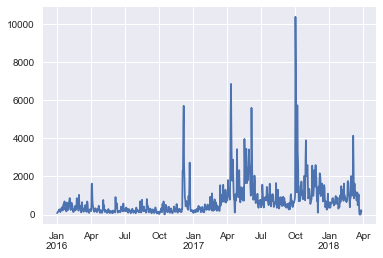

In [363]:
pd.to_datetime(df['created_at_utc']).value_counts().resample('1D').sum().plot()

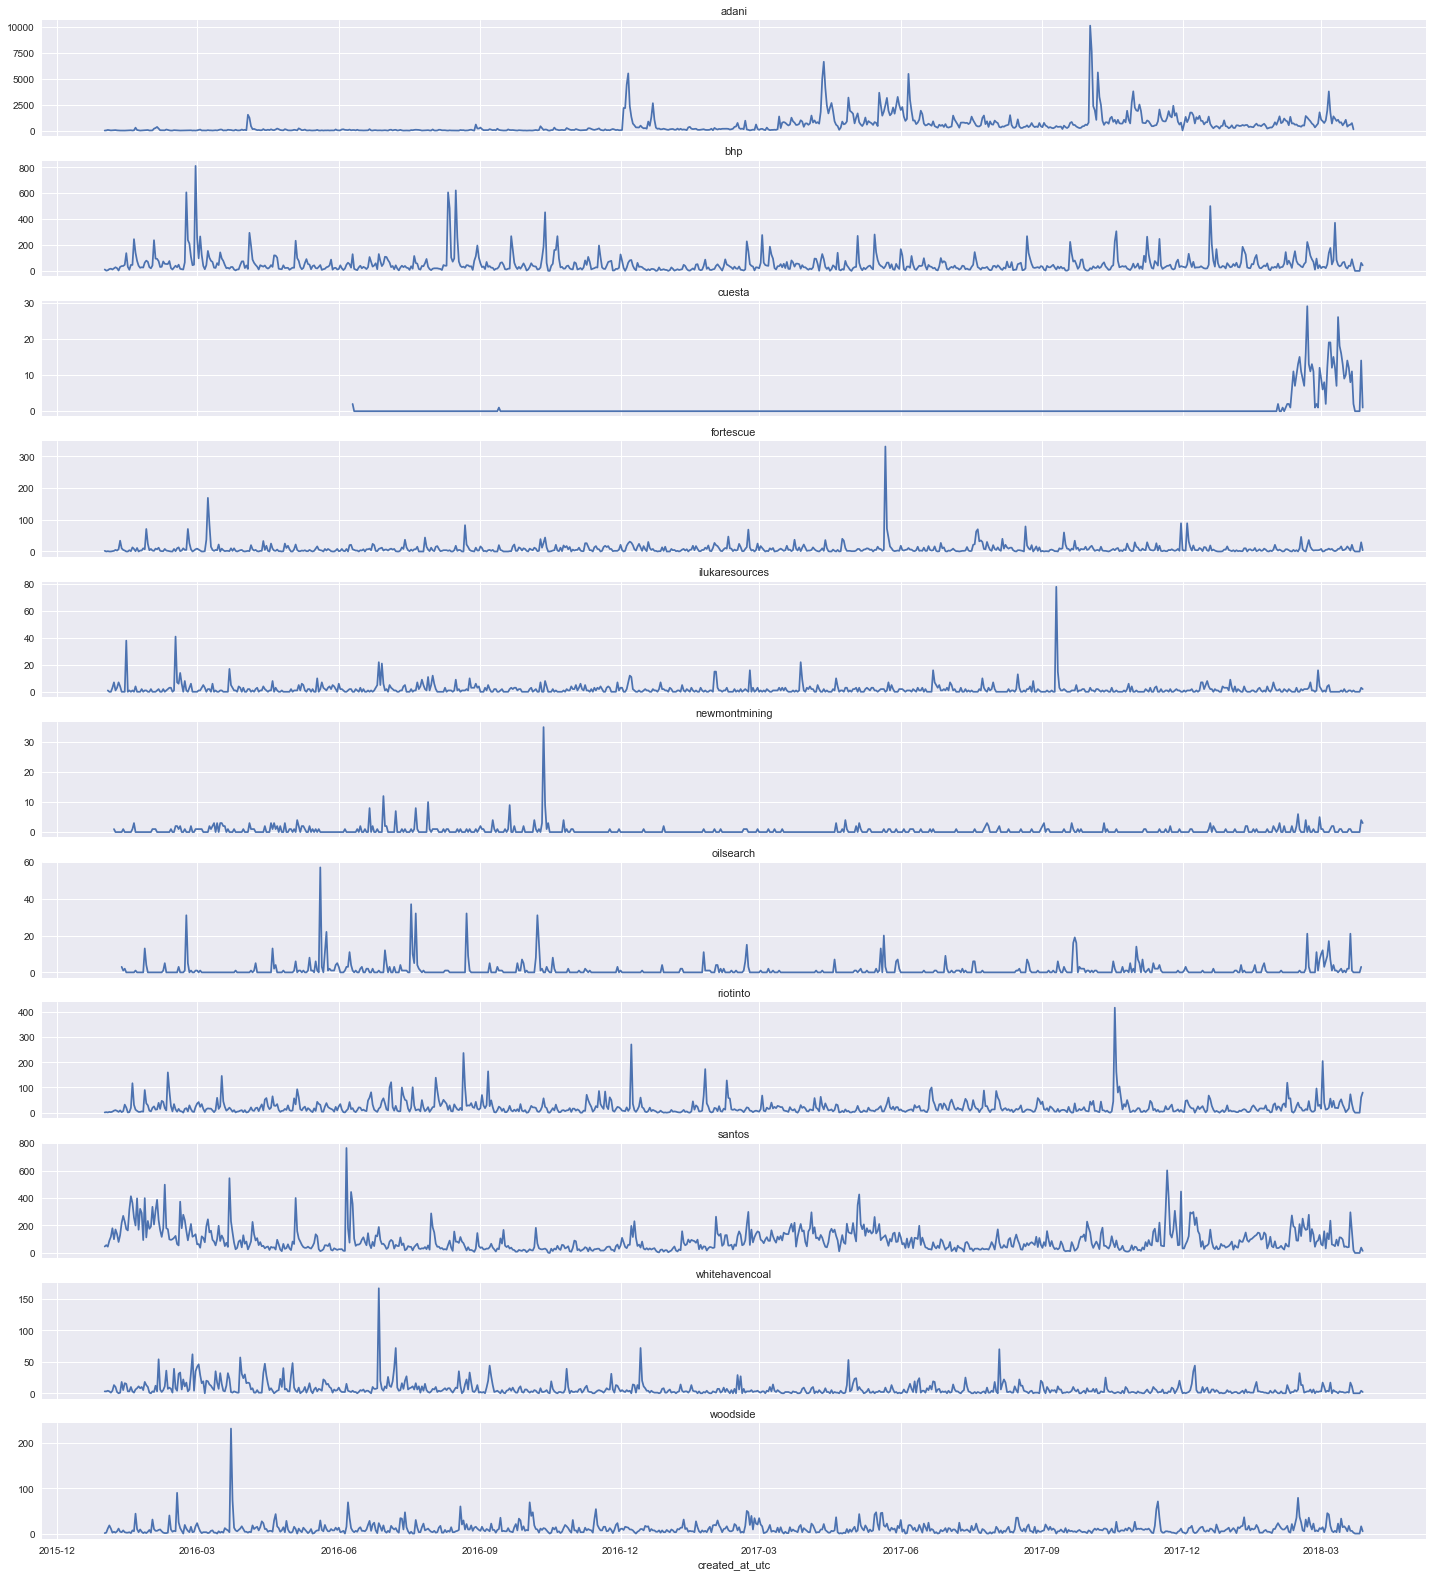

In [371]:
def ts_plot(col, **kwargs):
    ax = plt.gca()
    data = kwargs.pop('data')
    ts = pd.to_datetime(data[col]).value_counts().resample('1D').sum()
    ax.plot(ts)

grid = sns.FacetGrid(df[['created_at_utc', 'company']], row='company', size=2, aspect=10, sharey=False)
grid.map_dataframe(ts_plot, 'created_at_utc').set_titles('{row_name}')

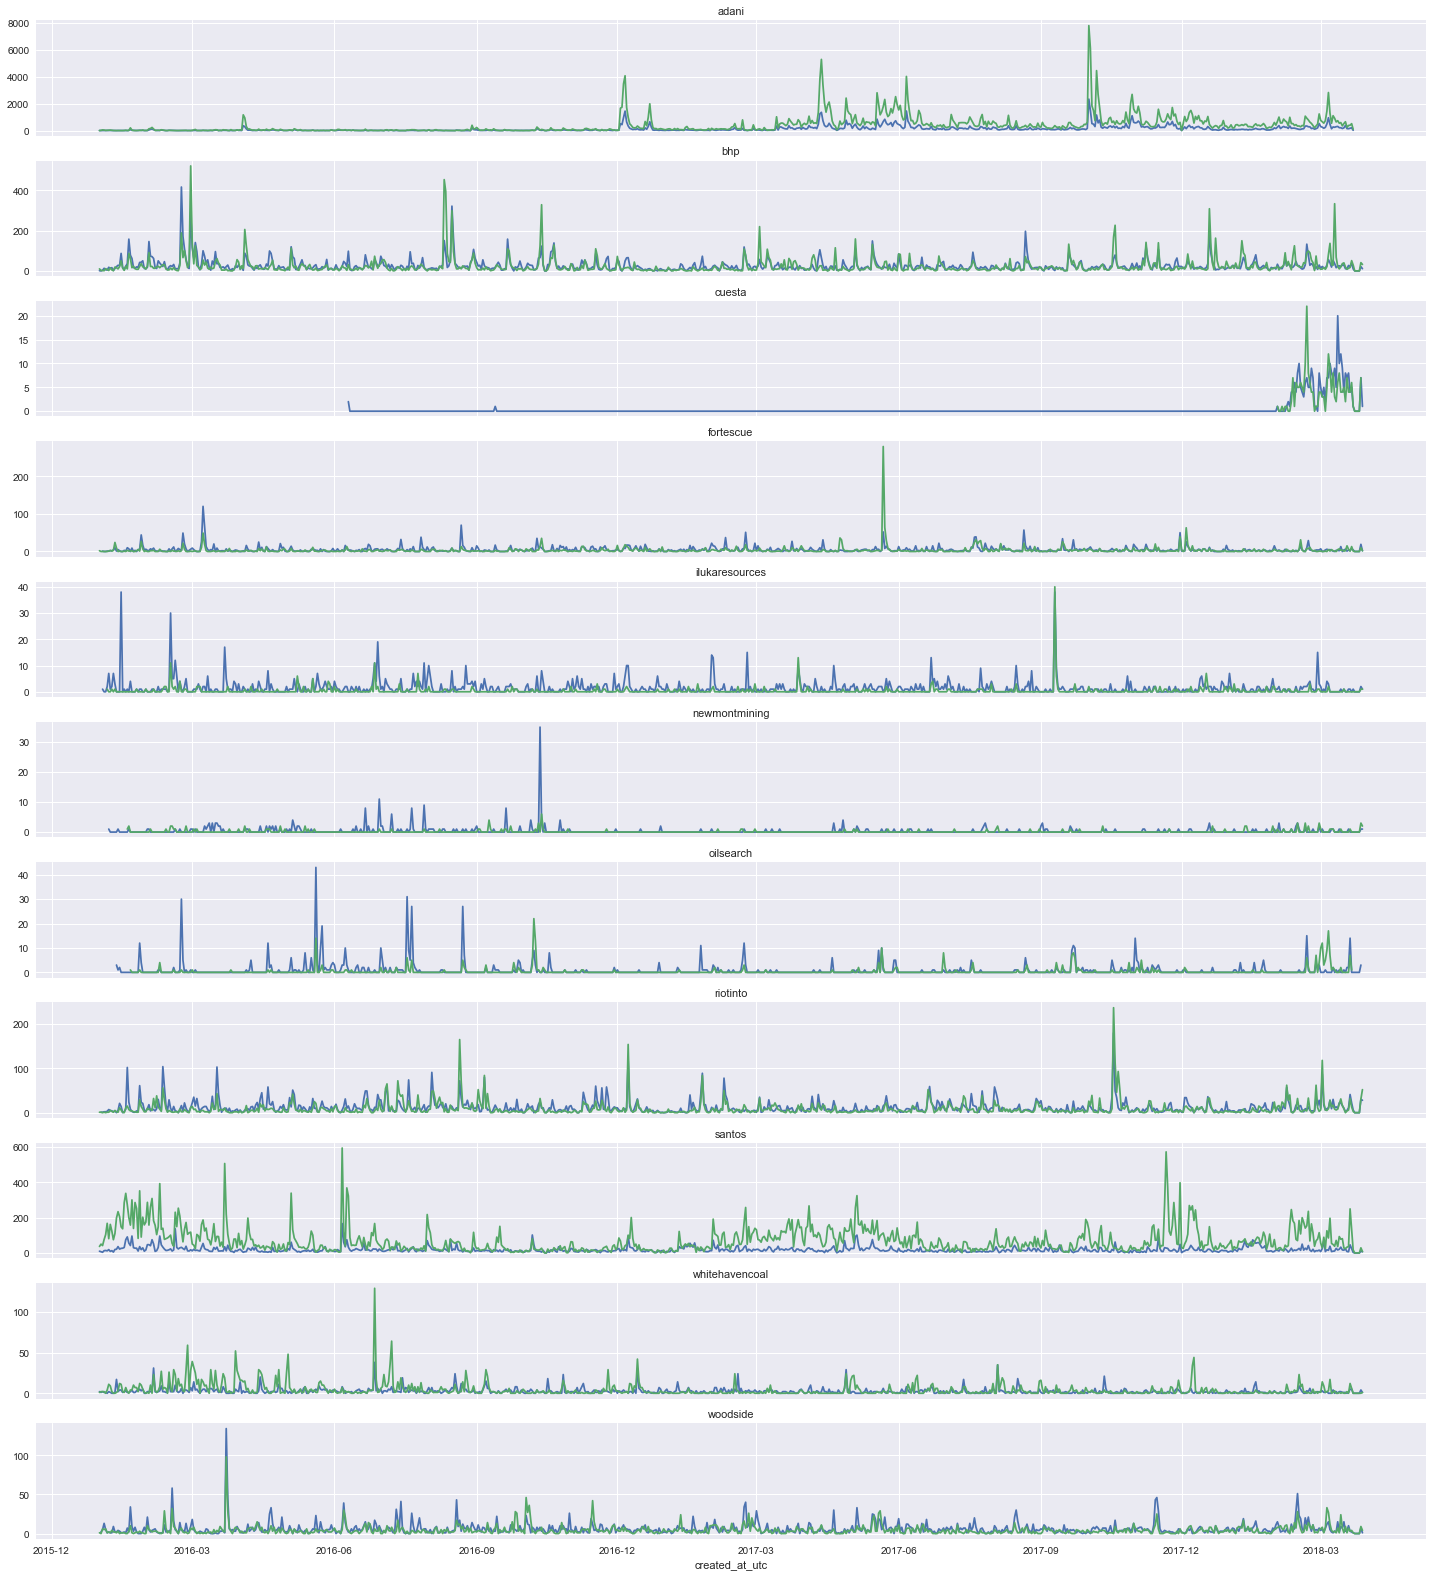

In [370]:
def ts_plot(col, **kwargs):
    ax = plt.gca()
    data = kwargs.pop('data')
    ts_rt = pd.to_datetime(data.query("retweet_flag == 'Y'")[col]).value_counts().resample('1D').sum()
    ts = pd.to_datetime(data.query("retweet_flag == 'N'")[col]).value_counts().resample('1D').sum()
    ax.plot(ts)
    ax.plot(ts_rt)

grid = sns.FacetGrid(df[['retweet_flag', 'created_at_utc', 'company']], row='company', size=2, aspect=10, sharey=False)
grid.map_dataframe(ts_plot, 'created_at_utc').set_titles('{row_name}')

peak points must be correrated to some events

### Retweets

In [92]:
df['retweet_flag'].value_counts()

Y     425468
N     169012
YC       150
Name: retweet_flag, dtype: int64

In [93]:
for row in df.query("retweet_flag == 'YC'").tweet.sample(10):  # they seem Quoted Tweets
    print(row)

.#FrackingArsehole #Santos #CSG #auspol RT @LandWaterFuture https://t.co/6efhgFPns8
.#FrackingArsehole #Santos says Ozzies benefit f.clean #natgas &amp; stuff the #GreatArtesianBasin #auspol RT @SantosLtd https://t.co/zBV1mwPhSW
Done. Thanks @Tallyvision RT @Tallyvision: Please RSVP: Stop Adani Human Sign - Bendigo https://t.co/uuzUFoWXaQ
.#FrackingArsehole @SantosLtd #CSG #auspol RT @MayneReport @AustralisTerry https://t.co/PJE9P3LZ0D
.#FrackingArsehole #Santos #auspol #CSG #GreatArtesianBasian RT @protecttheplain @SantosLtd https://t.co/0nJFKV5M7U
.#FrackingArsehole @SantosLtd RT @1EarthMedia @CRAG_Coona https://t.co/Z6FJRBQb7j
Shouldn't you be doing your actual PUBLIC SERVANT job on Friday?? RT @Sarahinthesen8 This Friday join me...in #Adelaide to help #StopAdani
#qldpol 
RT @AYCC 
The first rule of #StopAdani club?
Tell everyone about #StopAdani club.
https://t.co/Hx79qbmNby  https://t.co/GmAW3ETqfs
.#FrackingArsehole @SantosLtd RT @L_DeWeaver @GregHuntMP @LandWaterFuture @mikebair

In [94]:
def bar_plot(col, **kwargs):
    ax = plt.gca()
    data = kwargs.pop('data')
    height = data[col].value_counts(normalize=True)
    height.sort_index(inplace=True)
    ax.bar(height.index, height)

company         retweet_flag
adani           N               107594
                Y               328445
                YC                  30
bhp             N                22201
                Y                20434
                YC                   4
cuesta          N                  269
                Y                  216
fortescue       N                 4234
                Y                 2849
                YC                   2
ilukaresources  N                 1257
                Y                  326
newmontmining   N                  294
                Y                  116
oilsearch       N                  748
                Y                  333
riotinto        N                 9958
                Y                 7524
santos          N                15258
                Y                58148
                YC                 110
whitehavencoal  N                 2131
                Y                 3445
                YC                 

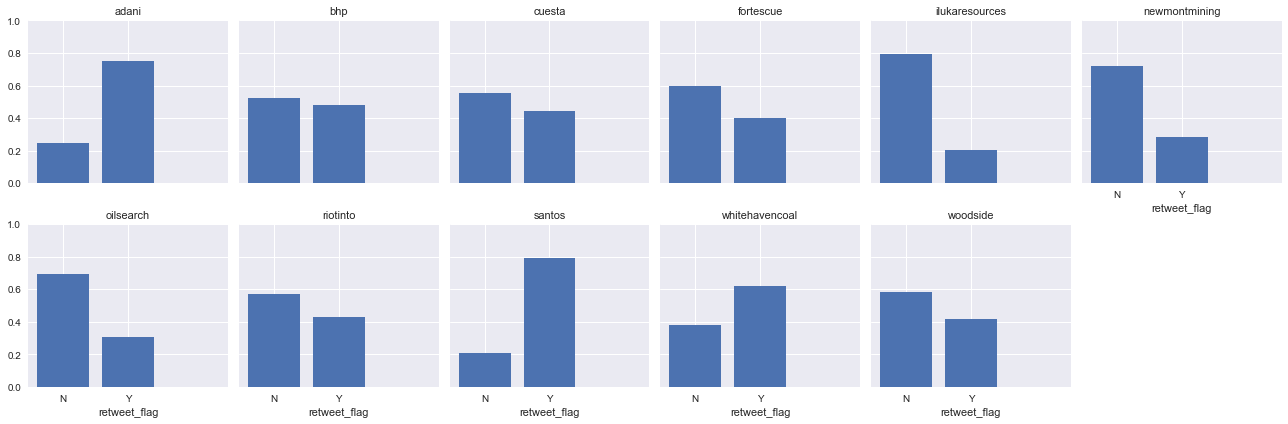

In [361]:
print(df.groupby(['company', 'retweet_flag']).size())
grid = sns.FacetGrid(df[['retweet_flag', 'company']], col='company', col_wrap=6, ylim=(0, 1))
grid.map_dataframe(bar_plot, 'retweet_flag').set_titles('{col_name}')

many of RTs

In [96]:
def bar_plot_zipf(col, **kwargs):
    ax = plt.gca()
    data = kwargs.pop('data')
    height = data[col].value_counts().value_counts(normalize=True)
    ax.bar(height.index, height)

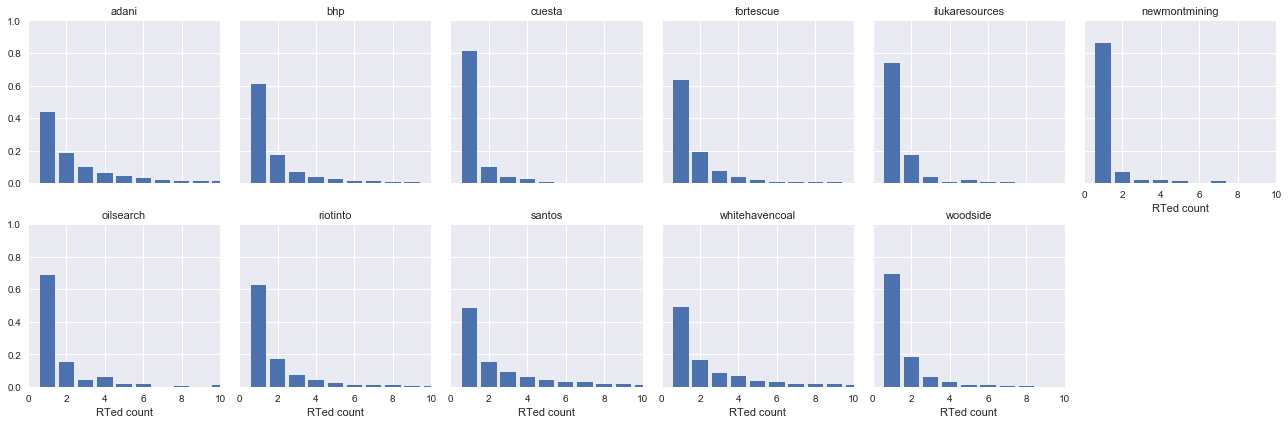

In [97]:
grid = sns.FacetGrid(df[['original_tweet_id', 'company']], col='company', col_wrap=6, ylim=(0, 1), xlim=(0, 10))
grid.map_dataframe(bar_plot_zipf, 'original_tweet_id').set_titles('{col_name}').set_xlabels('RTed count')

#### RT counts of top RTed tweets

In [98]:
df[['company', 'original_tweet_id']].groupby('company')\
    .apply(lambda x: x['original_tweet_id'].value_counts().value_counts(normalize=True)\
                                           .sort_index(ascending=False).head(3))

company            
adani           827    0.000014
                647    0.000014
                545    0.000014
bhp             323    0.000139
                209    0.000139
                177    0.000139
cuesta          24     0.007092
                13     0.007092
                5      0.007092
fortescue       247    0.000766
                68     0.000766
                38     0.000766
ilukaresources  12     0.004587
                7      0.009174
                6      0.004587
newmontmining   7      0.011364
                5      0.011364
                4      0.022727
oilsearch       17     0.005348
                10     0.010695
                8      0.005348
riotinto        132    0.000302
                74     0.000302
                57     0.000302
santos          681    0.000064
                187    0.000064
                146    0.000064
whitehavencoal  81     0.000985
                73     0.000985
                38     0.000985
woodside        49  

#### Portion of top RTed tweets

In [99]:
df[['company', 'original_tweet_id']].groupby('company')\
    .apply(lambda x: x['original_tweet_id'].value_counts(normalize=True).head())

company                     
adani           8.718998e+17    0.002518
                8.049490e+17    0.001970
                9.386611e+17    0.001660
                9.418050e+17    0.001632
                9.147907e+17    0.001090
bhp             9.722877e+17    0.015819
                9.443807e+17    0.010236
                8.374247e+17    0.008668
                9.627996e+17    0.008521
                9.711408e+17    0.007444
cuesta          9.658084e+17    0.111111
                9.711269e+17    0.060185
                9.655099e+17    0.023148
                9.646249e+17    0.018519
                9.671954e+17    0.018519
fortescue       8.664509e+17    0.086880
                8.564207e+17    0.023918
                9.375533e+17    0.013366
                8.664654e+17    0.007738
                8.664848e+17    0.007738
ilukaresources  9.067037e+17    0.037037
                9.066999e+17    0.021605
                9.424955e+17    0.021605
                7.364849e+17

Popular RTs constitute 1–10% of each company's data

### Users

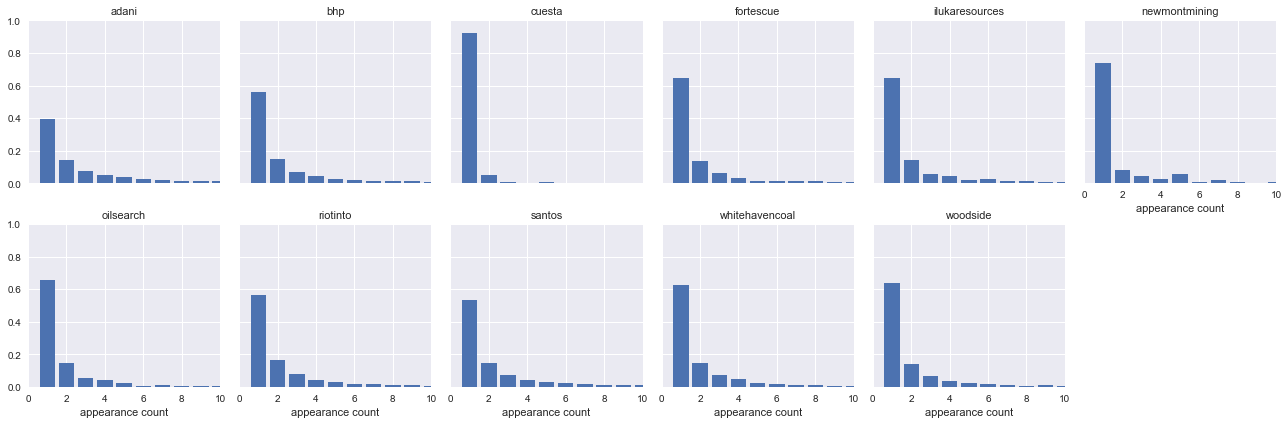

In [100]:
grid = sns.FacetGrid(df[['user_id', 'company']], col='company', col_wrap=6, ylim=(0, 1), xlim=(0, 10))
grid.map_dataframe(bar_plot_zipf, 'user_id').set_titles('{col_name}').set_xlabels('appearance count')

most users appear only once

In [372]:
df[['company', 'screen_name']].groupby('company')\
    .apply(lambda x: x['screen_name'].value_counts(normalize=True).head())#.value_counts(normalize=True)\
                                           #.sort_index(ascending=False).head())

company                        
adani           WgarNews           0.013746
                GalileeBlockade    0.009090
                blanketcrap        0.009022
                LelHulagirl63      0.007338
                MarkPlackett1      0.007194
bhp             CommSec            0.024555
                aus_business       0.017707
                FinancialReview    0.011046
                Bell_Potter        0.009874
                3novicesSydney     0.008982
cuesta          Marana_tha         0.030928
                rjstrikers         0.020619
                arimefrance        0.014433
                LeagueUnlimited    0.010309
                MethaqAbdullah     0.010309
fortescue       FortescueNews      0.034016
                aus_business       0.021877
                FinancialReview    0.014255
                CommSec            0.011150
                3novicesSydney     0.010727
ilukaresources  BayplayTours       0.031586
                ilubphotography    0.030322


the most frequent user's tweets constitute more than 1% of each company's data

----

## Linguistic Characteristics

### Character counts

In [102]:
def relhist_proc(col, **kwargs):
    ax = plt.gca()
    data = kwargs.pop('data')
    proc = kwargs.pop('proc')
    processed = proc(data[col])
    # relative frequency histgram
    # https://stackoverflow.com/questions/9767241/setting-a-relative-frequency-in-a-matplotlib-histogram
    ax.hist(processed, weights=np.ones_like(processed) / processed.size , **kwargs)

In [103]:
def char_len(tweets):
    return tweets.str.len()

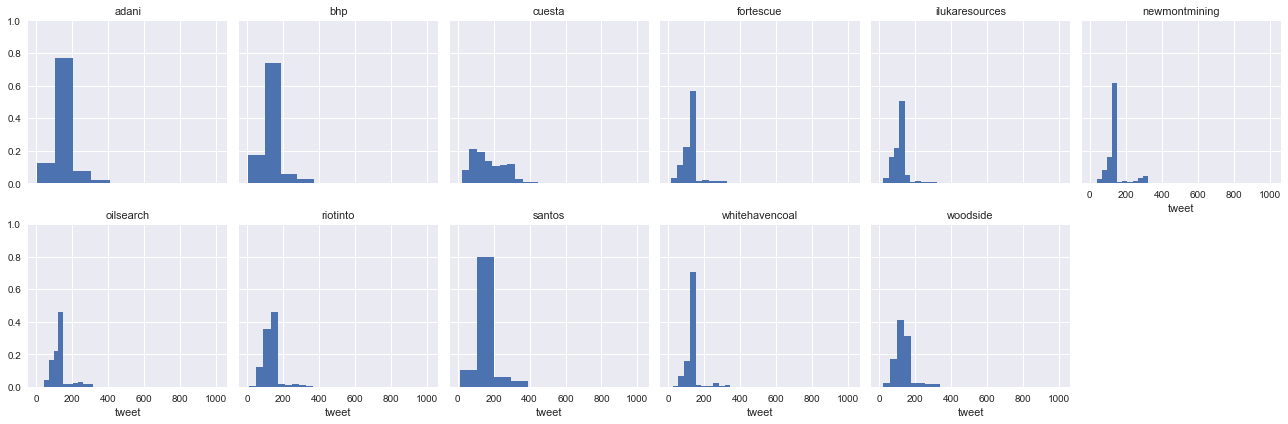

In [373]:
grid = sns.FacetGrid(df[['tweet', 'company']], col='company', col_wrap=6, ylim=(0, 1))
grid.map_dataframe(relhist_proc, 'tweet', bins=10, proc=char_len).set_titles('{col_name}')

relatively long

### Word counts (word token)

In [374]:
pos_tweets = POStagger.runtagger_parse(df['tweet'].str.replace(r"[\t\n\r]", ' ').str.replace(r"^RT @[a-zA-Z_0-9]+: ", ''))

In [375]:
df_tokens = pd.concat([df.company, pd.Series(pos_tweets, name='tokens')], axis=1)
df_tokens.head()

,company,tokens
0,adani,"[(@CFMEUWA, @, 0.9983), (@01507db5dba34b2, @, ..."
1,adani,"[(Kind, N, 0.6059), (of, P, 0.9852), (embarras..."
2,adani,"[(Stand, V, 0.9089), (with, P, 0.9982), (them,..."
3,adani,"[(Adani's, Z, 0.6777), (Carmichael, ^, 0.9944)..."
4,adani,"[("", ,, 0.9893), (We're, L, 0.9092), (swimming..."


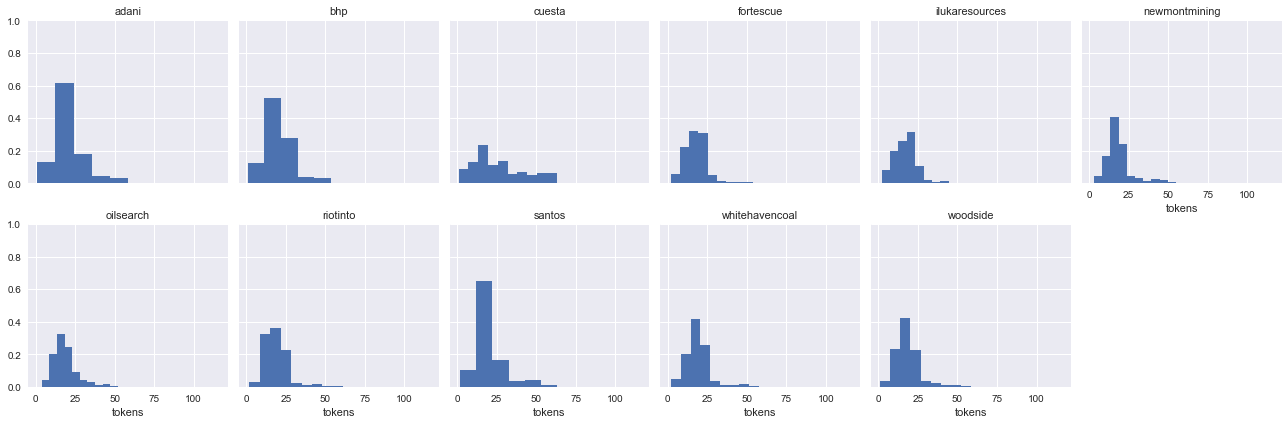

In [109]:
# run after CMUTweetTagger applied
grid = sns.FacetGrid(df_tokens[['tokens', 'company']], col='company', col_wrap=6, ylim=(0, 1))
grid.map_dataframe(relhist_proc, 'tokens', proc=lambda x: x.apply(len)).set_titles('{col_name}')

word-wise, not so long?

### word types (unique words)

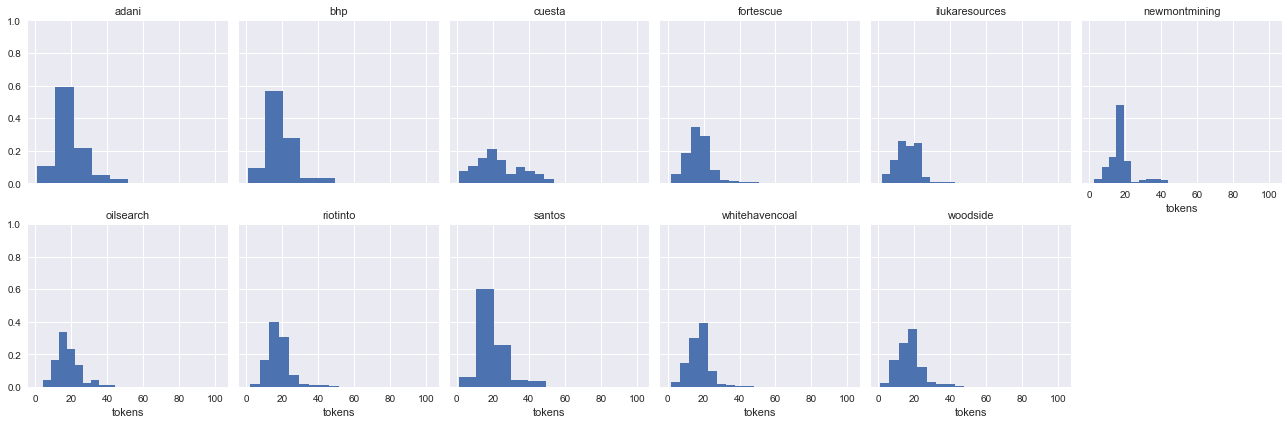

In [111]:
# run after CMUTweetTagger applied
grid = sns.FacetGrid(df_tokens[['tokens', 'company']], col='company', col_wrap=6, ylim=(0, 1))
grid.map_dataframe(relhist_proc, 'tokens', proc=lambda x: x.apply(lambda y: len(set([t for t, p, _ in y])))).set_titles('{col_name}')

similar to word counts

#### Word redundancy

For each tweet, word type counts are subtracted from word token counts, which produces redundant words

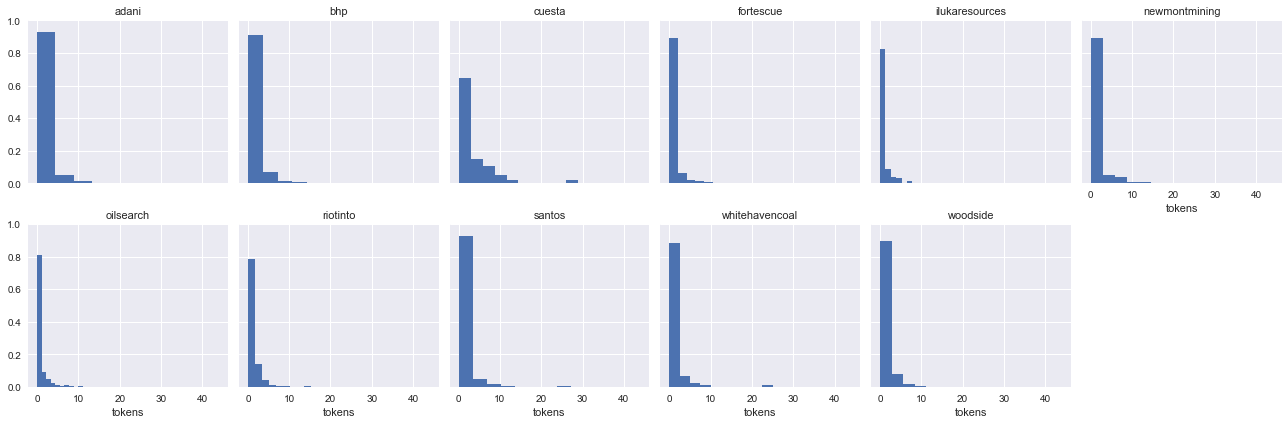

In [112]:
# run after CMUTweetTagger applied
grid = sns.FacetGrid(df_tokens[['tokens', 'company']], col='company', col_wrap=6, ylim=(0, 1))
grid.map_dataframe(relhist_proc, 'tokens', proc=lambda x: x.apply(len) - x.apply(lambda y: len(set([t for t, p, _ in y])))).set_titles('{col_name}')

most tweets has no redundant words; most tweets are composed of unique words

### Hashtags

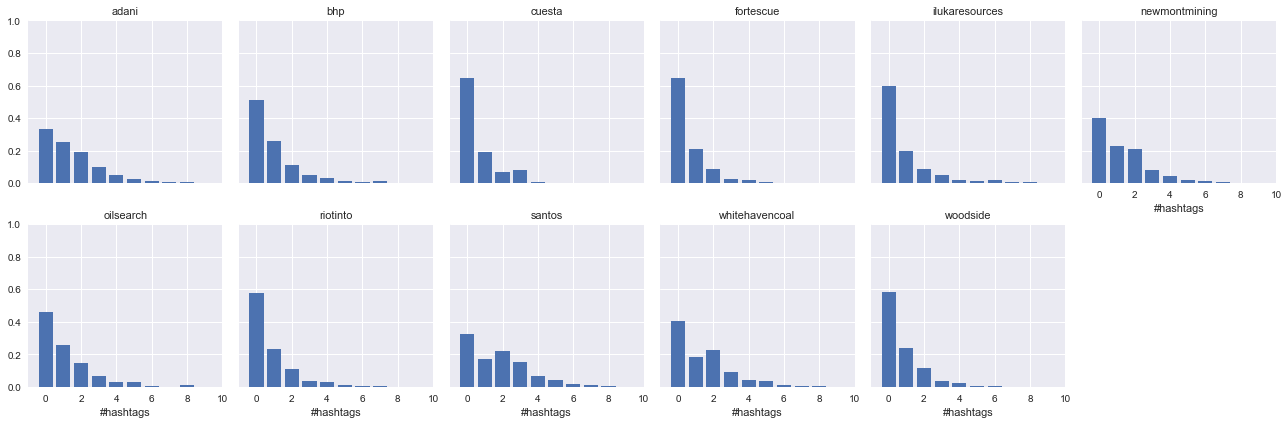

In [120]:
# the number of hashtags within tweets
df['#hashtags'] = df['hashtags'].apply(lambda x: len(x) if x is not None else 0)
# companies = df['company']

grid = sns.FacetGrid(df[['#hashtags', 'company']], col='company', col_wrap=6, ylim=(0, 1), xlim=(-1, 10))
grid.map_dataframe(bar_plot, '#hashtags').set_titles('{col_name}')

many tweets have some hashtags

In [379]:
# top hashtags
df[['company', 'hashtags']].groupby('company')\
    .apply(lambda x: pd.Series([hashtag 
                                for hashtags in x['hashtags'] if hashtags is not None 
                                for hashtag in hashtags])\
                               .value_counts(normalize=True)\
                               .head())

company                            
adani           StopAdani              0.174300
                auspol                 0.140580
                Adani                  0.112661
                qldpol                 0.051298
                adani                  0.039397
bhp             auspol                 0.111317
                BHP                    0.076530
                ausbiz                 0.072103
                coal                   0.022254
                ASX                    0.019841
cuesta          auspol                 0.101796
                savotes2018            0.074850
                saparli                0.074850
                IWD2018                0.053892
                الغوطة_تغرق_بالدماء    0.014970
fortescue       ausbiz                 0.105503
                auspol                 0.042065
                Fortescue              0.041610
                ironore                0.027740
                ASX                    0.022510
iluk

In [381]:
# top hashtags, lower-cased
df[['company', 'hashtags']].groupby('company')\
    .apply(lambda x: pd.Series([hashtag.lower() 
                                for hashtags in x['hashtags'] if hashtags is not None 
                                for hashtag in hashtags])\
                               .value_counts(normalize=True)\
                               .head())

company                       
adani           stopadani         0.198764
                auspol            0.155947
                adani             0.154569
                qldpol            0.057222
                coal              0.036508
bhp             auspol            0.117103
                bhp               0.083160
                ausbiz            0.074281
                asx               0.023566
                shenhua           0.023566
cuesta          auspol            0.101796
                saparli           0.074850
                savotes2018       0.074850
                iwd2018           0.053892
                الغوطة_الشرقية    0.014970
fortescue       ausbiz            0.109141
                auspol            0.054343
                fortescue         0.049795
                ironore           0.031151
                asx               0.024557
ilukaresources  iluka             0.087047
                ausbiz            0.038997
                austral

### Mentions

In [382]:
df['user_mentions'].count() / len(df)

0.47700418747792744

In [383]:
df['in_reply_to_status_id'].count() / len(df)

0.05714982426046449

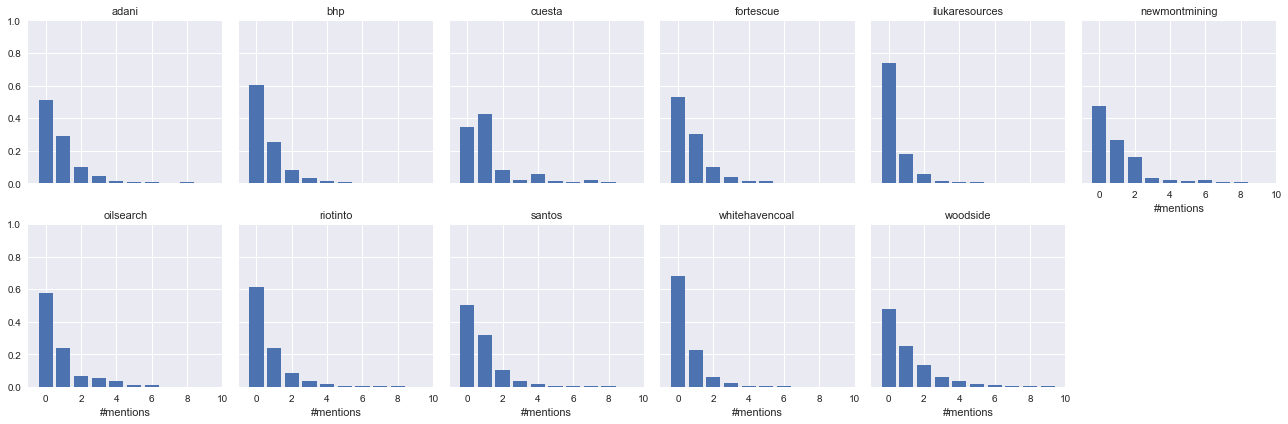

In [123]:
# the number of mentions within tweets
df['#mentions'] = df['user_mentions'].apply(lambda x: len(x) if isinstance(x, list) else 0)

grid = sns.FacetGrid(df[['#mentions', 'company']], col='company', col_wrap=6, ylim=(0, 1), xlim=(-1, 10))
grid.map_dataframe(bar_plot, '#mentions').set_titles('{col_name}')

there are even substantial multi-mention tweets.

In [380]:
# top mentions
df[['company', 'user_mentions']].groupby('company')\
    .apply(lambda x: pd.Series([mention 
                                for mentions in x['user_mentions'] if mentions is not None 
                                for mention in mentions])\
                               .value_counts(normalize=True)\
                               .head())

company                        
adani           AnnastaciaMP       0.053558
                TurnbullMalcolm    0.036185
                stopadani          0.031048
                billshortenmp      0.028363
                StopAdaniCairns    0.018098
bhp             bhpbilliton        0.106112
                bhp                0.105170
                SwannyQLD          0.029961
                abcnews            0.020251
                TurnbullMalcolm    0.020179
cuesta          cqc2t_             0.070175
                ausoftheyear       0.038012
                AntonyGreenABC     0.035088
                BoltzmannMick      0.023392
                UNSW               0.021930
fortescue       FortescueNews      0.213434
                fortescue          0.156735
                smh                0.021488
                FinancialReview    0.016793
                Hockeyroos         0.011737
ilukaresources  IlukaResources     0.208791
                ilukamusic         0.040816


stance-fixed users such as `@stopadani` might contribute

### Stock symbols

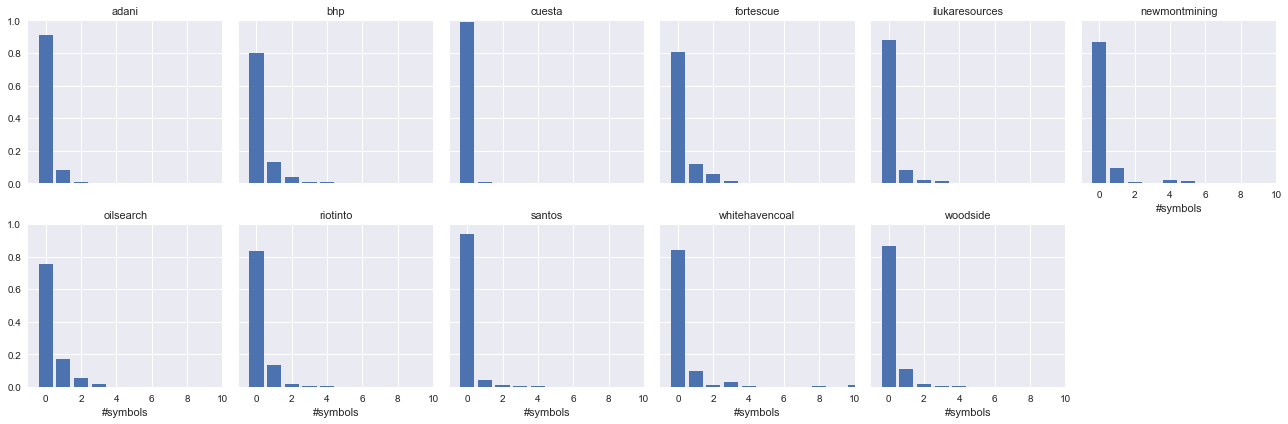

In [124]:
df['#symbols'] = df.tweet.str.findall(r"\$\w+").apply(len)

grid = sns.FacetGrid(df[['#symbols', 'company']], col='company', col_wrap=6, ylim=(0, 1), xlim=(-1, 10))
grid.map_dataframe(bar_plot, '#symbols').set_titles('{col_name}')

In [385]:
(df['#symbols'] > 0).sum() / len(df)

0.09872862115937642

companies are sometimes mentioned by stock symbols

### URLs

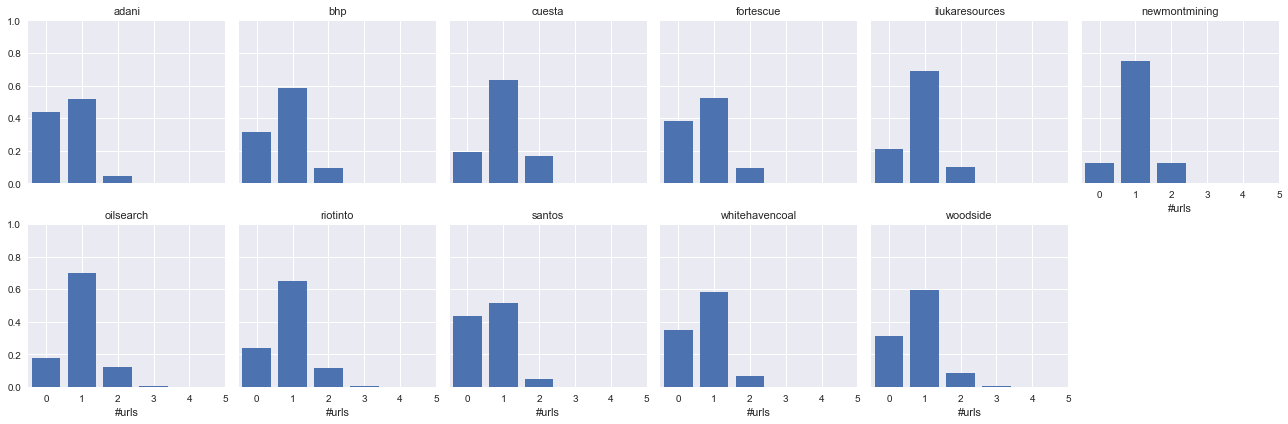

In [133]:
import re
ptn_url = re.compile(r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+")
df['#urls'] = df.tweet.str.findall(ptn_url).apply(len)

grid = sns.FacetGrid(df[['#urls', 'company']], col='company', col_wrap=6, ylim=(0, 1), xlim=(-0.5, 5))
grid.map_dataframe(bar_plot, '#urls').set_titles('{col_name}')

In [384]:
(df['#urls'] > 0).sum() / len(df)

0.5801372281923213

over a half of tweets have URLs.
According to one company analysis, most of them are very likely to be news articles

### Emojis

In [136]:
ptn_emoji = emoji.get_emoji_regexp()
df.tweet.str.contains(ptn_emoji).any()

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  


True

In [167]:
df['emojis'] = df.tweet.str.extractall(ptn_emoji).groupby(level=0).apply(lambda x: x.values.flatten())

In [178]:
df['emojis'].notnull().sum() / len(df)

0.03406151724601853

In [245]:
df['#emojis'] = df['emojis'].apply(lambda x: len(x) if x is not np.nan else 0)

In [253]:
# emoji-bearing tweets
df[['company', '#emojis']].groupby('company').apply(lambda x: 1 - x['#emojis'].value_counts(normalize=True).loc[0])

company
adani             0.036256
bhp               0.018410
cuesta            0.074227
fortescue         0.034580
ilukaresources    0.036008
newmontmining     0.026829
oilsearch         0.011101
riotinto          0.018019
santos            0.027477
whitehavencoal    0.112366
woodside          0.038621
dtype: float64

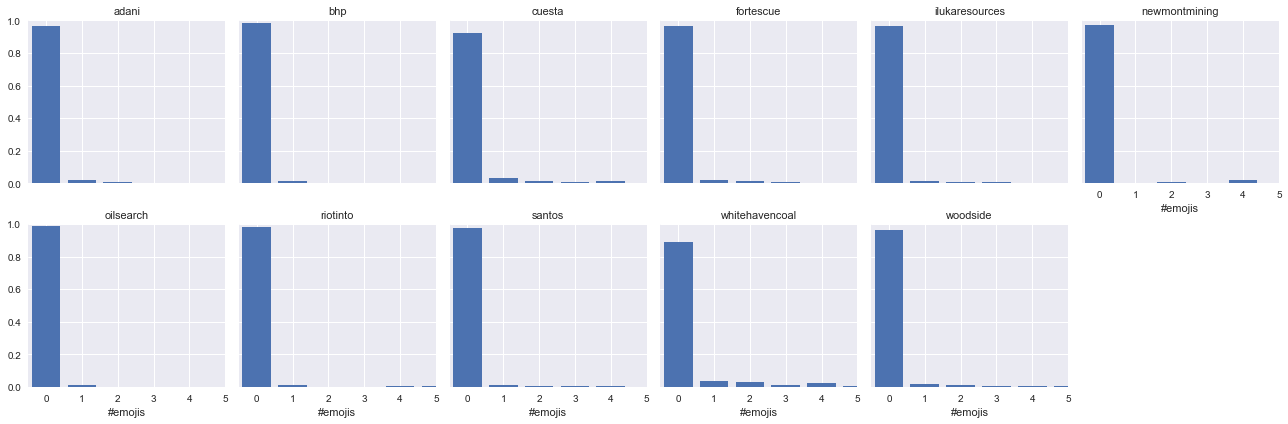

In [248]:
grid = sns.FacetGrid(df[['#emojis', 'company']], col='company', col_wrap=6, ylim=(0, 1), xlim=(-0.5, 5))
grid.map_dataframe(bar_plot, '#emojis').set_titles('{col_name}')

#### Popular emojis

In [231]:
df[['company', 'emojis']][df['emojis'].notnull()].groupby('company')\
    .apply(lambda x: pd.Series([emoji for emojis in x['emojis'] for emoji in emojis])\
                              .value_counts(normalize=True).head())

company          
adani           😡    0.070632
                💰    0.064943
                👏    0.044041
                👎    0.041101
                🏭    0.031545
bhp             💰    0.124640
                😂    0.048271
                👏    0.036744
                ⭐    0.036744
                😡    0.030980
cuesta          💕    0.131579
                😝    0.065789
                💦    0.065789
                😍    0.039474
                💪    0.039474
fortescue       💰    0.322967
                😡    0.165072
                👉    0.057416
                👈    0.057416
                ⭐    0.043062
ilukaresources  ❤    0.105691
                ☀    0.073171
                ⭐    0.056911
                😍    0.048780
                📷    0.032520
newmontmining   👉    0.432432
                👈    0.432432
                👍    0.054054
                ⭐    0.027027
                👌    0.027027
oilsearch       ⭐    0.277778
                😠    0.166667
                🐉    0

Angry faced emojis and laughing emojis are likely to be stance against companies.
Emojis are very infrequent, but considering their emotions would be useful.

### Word Frequency

here, not consider tweet-wise splitting.
investigate bag-of-words for each company

**CMU Tweet POS Tagger** is used in this analysis

In [88]:
df_tokpos = df_tokens.groupby('company')\
                     .apply(lambda x: pd.DataFrame.from_records(
                         [(token, pos) for tokens_ea in x['tokens'] for token, pos, p in tokens_ea],
                         columns=['word', 'pos']))\
                     .reset_index().drop('level_1', axis=1)

In [89]:
df_tokpos.isnull().any()

company    False
word       False
pos        False
dtype: bool

#### total words by CMU tagger

In [263]:
token_sizes = df_tokpos.groupby('company').size()
token_sizes

company
adani             9233519
bhp                854515
cuesta              12821
fortescue          127900
ilukaresources      27052
newmontmining        7745
oilsearch           20048
riotinto           328984
santos            1527617
whitehavencoal     105178
woodside           158611
dtype: int64

#### Total types

vocabularies of company tweet data

In [377]:
df_tokpos.groupby('company').apply(lambda x: len(x['word'].unique()))

company
adani             183884
bhp                59804
cuesta              4432
fortescue          15924
ilukaresources      6313
newmontmining       2241
oilsearch           3938
riotinto           29627
santos             68928
whitehavencoal     10896
woodside           21666
dtype: int64

In [265]:
# TTR (type/token ratio; a measure of lexical diversity)
df_tokpos.groupby('company').apply(lambda x: len(x['word'].unique())) / token_sizes

company
adani             0.019915
bhp               0.069986
cuesta            0.345683
fortescue         0.124504
ilukaresources    0.233365
newmontmining     0.289348
oilsearch         0.196429
riotinto          0.090056
santos            0.045121
whitehavencoal    0.103596
woodside          0.136598
dtype: float64

#### Hapax legomena 

words that appear only once (unique words)

In [309]:
df_tokpos.groupby('company').apply(lambda x: x['word'].value_counts().value_counts(normalize=True).loc[1])

company
adani             0.538258
bhp               0.575731
cuesta            0.711417
fortescue         0.536046
ilukaresources    0.583716
newmontmining     0.623382
oilsearch         0.550533
riotinto          0.565970
santos            0.509169
whitehavencoal    0.517254
woodside          0.530970
dtype: float64

over a half tokens appear only once.
training their embeddings would be difficult.

#### POS tag distributions

##### POS tag description

- N common noun
- O pronoun (personal/WH; not possessive)
- ^ proper noun
- S nominal + possessive
- Z proper noun + possessive
- V verb including copula, auxiliaries
- L nominal + verbal (e.g. i’m), verbal + nominal (let’s)
- M proper noun + verbal
- A adjective
- R adverb
- ! interjection
- D determiner
- P pre- or postposition, or subordinating conjunction
- & coordinating conjunction
- T verb particle
- X existential there, predeterminers
- Y X + verbal
- \# hashtag (indicates topic/category for tweet)
- @ at-mention (indicates a user as a recipient of a tweet)
- ~ discourse marker, indications of continuation across multiple tweets
- U URL or email address
- E emoticon
- $ numeral
- , punctuation
- G other abbreviations, foreign words, possessive endings, symbols, garbage


In [62]:
# example words for POS tags
df_tokpos.groupby('company').get_group('bhp').groupby('pos').apply(lambda x: set(x.sample(10)['word'].values))

pos
!               {LOL, Congrats, Yep, Dam, yes, o, dam}
#    {#ACES2016, #stocks, #iron_ore, #mining, #COP2...
$    {$20.71, 8.8%, one, $7.2, $5.89, 2billion, 0.2...
&                                          {and, &, +}
,                                 {?, ???, :, ,, -, .}
@    {@abcnews, @RioTinto, @twensor, @p_hannam, @Co...
A    {new, full, economic, keen, industrial, bn, Sh...
D                                             {the, a}
E                                         {xx, :/, :)}
G                       {s, ope, $220mn, $CTW, |, :::}
L     {Here's, they'r, it's, we've, its, Its, there's}
N    {PM, investors, tax, knife, challenge, 7yrs, f...
O        {He, this, Who, we, It, they, What, it, both}
P                   {up, of, over, in, by, as, on, As}
R    {almost, straight, so, actually, nearly, No, d...
S    {world's, tonight's, miner's, today's, company's}
T                                       {up, out, off}
U    {https://t.co/t5YhRMeCEI, https://t.co/0etpMmI...
V    {

In [63]:
# we can define following subsets of POS tags
content_tags   = "A E N R S V Z ^".split(' ')  # R maybe function
function_tags  = "! $ & , D G L O P T X ~".split(' ')
tweetmeta_tags = "# @ U".split(' ')

In [376]:
# check tokenisation/tagging results
for line in df_tokens.sample(20)['tokens'].apply(lambda x: ' '.join([t+'|'+p for t, p, _ in x])).values:
    if '#' in line:
        print('·', line)
# some hashtags used as (proper) nouns might be tagged as (proper) nouns

· Will|V be|V interested|V to|P hear|V how|R Department|N of|P Infrastructure|^ Canberra|^ explains|V strange|A rerouting|V of|P the|D Inland|^ Rail|^ route|N through|P Pilliga|^ forest|^ #Barnaby|^ #Santos|^ #estimates|N #auspol|# #Narrabri|# #nswpol|# #CSG|# https://t.co/7uFBhRfsuW|U
· An|D honest|A government|N advert|N on|P #Adani|^ Finally|R !|, An|D ad|N that|P cuts|V through|P the|D spin|N and|& tells|V it|O like|P it|O is|V !…|,
· Our|D message|N to|P the|D Chinese|A Govt|N :|, as|P clean|A energy|N leaders|N ,|, step|V in|P &|& block|V Chinese|A investors|N from|P financing|N Adani's|Z mine|N .|, It's|L bad|A for|P business|N ,|, the|D climate|N and|& Great|A Barrier|N Reef|N .|, #StopAdani|# #auspol|# https://t.co/ddFeUdOV29|U
· Euro|^ Close|^ Prices|N #STOXX600|# +|& 3.76|$ pt|N to|P 357.5|$ pts|N #FTSE100|# +78pts|^ #DAX|^ +|& 94.4|$ pts|N #CAC|N +43pts|V RIO|^ .|, UK|^ +|& 2.3%|$ BHP|^ .|, UK|^ +|& 2.78%|$ #ausbiz|# #markets|# #euro|#
· Watching|V #4Corners|^ @billshortenm

In [356]:
df_tokpos.query('pos != "#"')[df_tokpos.query('pos != "#"')['word'].str.startswith('#')].sample(20)

,company,word,pos
6319654,adani,#StopAdani,^
11918016,santos,#OVOPlay,^
10681554,santos,#csg,^
4458199,adani,#StopAdani,^
1053709,adani,#Adani,^
9188163,adani,#coal,N
10302747,riotinto,#AUSPOL,^
5992055,adani,#Adani,N
3247443,adani,#Adani,^
1003109,adani,#coal,N


In [293]:
df_posfreq = df_tokpos.groupby('company').apply(lambda x: pd.DataFrame(x['pos'].value_counts(normalize=True).rename('freq')))

In [294]:
df_posfreq.index.names = ['company', 'pos']
df_posfreq.head()

freq
company pos          
adani   N    0.187068
        V    0.143454
        ,    0.104557
        P    0.102368
        ^    0.078676

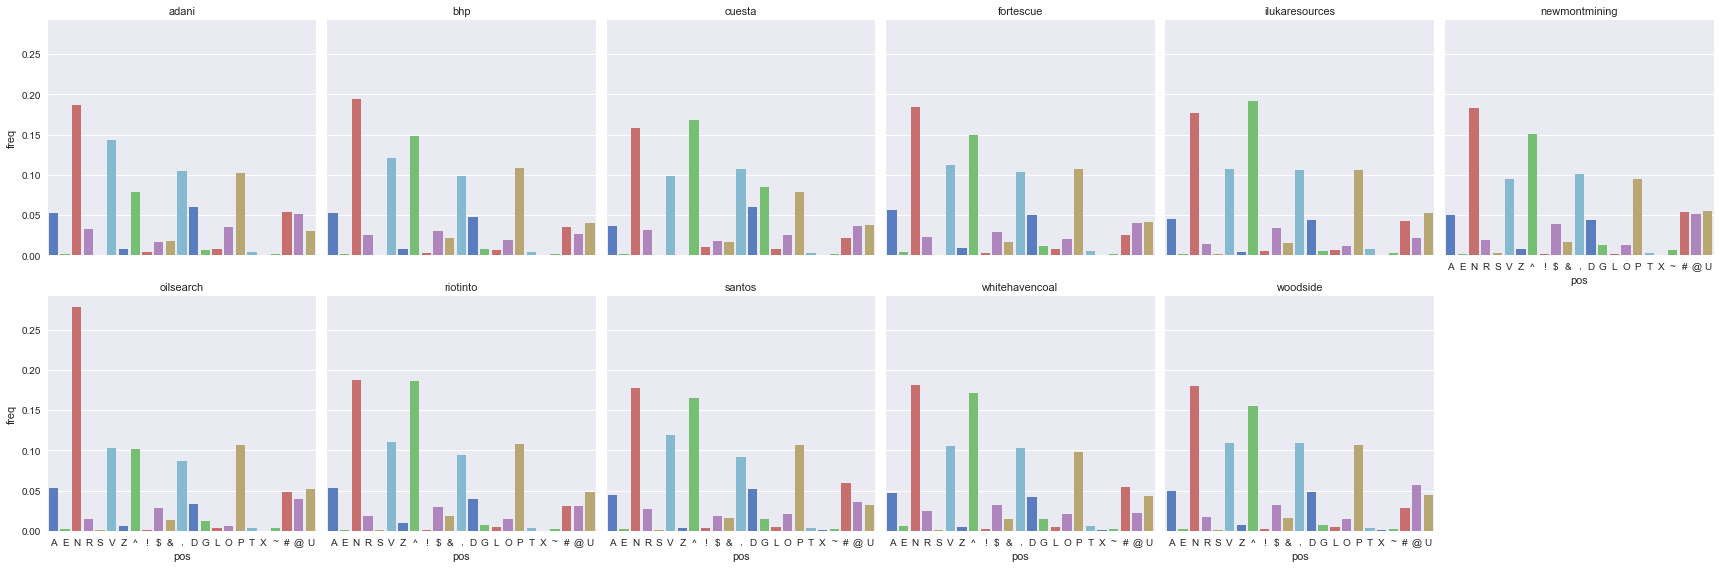

In [301]:
sns.factorplot(x='pos', y='freq', col='company', kind='bar', col_wrap=6, palette='muted', data=df_posfreq.reset_index(),
              order=[*content_tags, *function_tags, *tweetmeta_tags]).set_titles('{col_name}')

#### Content words

In [266]:
df_tokpos.groupby('company').apply(lambda x: len(x[x['pos'].isin(content_tags)])) / token_sizes

company
adani             0.504280
bhp               0.549089
cuesta            0.492785
fortescue         0.537451
ilukaresources    0.540330
newmontmining     0.509103
oilsearch         0.560754
riotinto          0.566714
santos            0.538789
whitehavencoal    0.540712
woodside          0.522316
dtype: float64

In [272]:
df_tokpos.groupby('company').apply(lambda x: x[x['pos'].isin(content_tags)]['word'].value_counts(normalize=True).head())

company                   
adani           Adani         0.040862
                is            0.019839
                coal          0.016516
                will          0.008748
                #Adani        0.008652
bhp             BHP           0.059300
                Billiton      0.012898
                is            0.012018
                tax           0.011773
                $BHP          0.007417
cuesta          cuesta        0.014562
                y             0.012029
                que           0.010288
                is            0.009180
                la            0.008705
fortescue       Fortescue     0.056619
                Metals        0.020279
                is            0.011944
                Group         0.009892
                ore           0.008161
ilukaresources  Iluka         0.085175
                Resources     0.013751
                NSW           0.008620
                has           0.007868
                is            0.00725

In [269]:
# emoticon
df_tokpos.groupby('company').apply(lambda x: len(x[x['pos'] == 'E'])) / token_sizes

company
adani             0.001608
bhp               0.001441
cuesta            0.001638
fortescue         0.003385
ilukaresources    0.002033
newmontmining     0.001033
oilsearch         0.001895
riotinto          0.001377
santos            0.002795
whitehavencoal    0.006085
woodside          0.002207
dtype: float64

In [255]:
df_tokpos.groupby('company').apply(lambda x: x[x['pos'] == 'E']['word'].value_counts(normalize=True).head())
# this includes emojis too

company               
adani           …         0.336408
                :/        0.314188
                😡         0.056966
                :)        0.026194
                👎         0.024645
bhp             …         0.320065
                :/        0.310317
                >         0.051178
                ❤         0.026807
                :)        0.023558
cuesta          X         0.238095
                🙏         0.047619
                ;-)       0.047619
                :)        0.047619
                😜         0.047619
fortescue       …         0.290993
                😡         0.159353
                :/        0.133949
                >         0.106236
                :)        0.092379
ilukaresources  >         0.236364
                :/        0.090909
                ❤         0.072727
                …         0.072727
                :)        0.054545
newmontmining   :/        0.250000
                >         0.250000
                …         0.2500

#### Function words

In [311]:
df_tokpos.groupby('company').apply(lambda x: len(x[x['pos'].isin(function_tags)])) / token_sizes

company
adani             0.359568
bhp               0.348652
cuesta            0.412994
fortescue         0.356888
ilukaresources    0.342747
newmontmining     0.331052
oilsearch         0.299880
riotinto          0.322766
santos            0.333173
whitehavencoal    0.340299
woodside          0.347965
dtype: float64

#### Twitter specific tags

In [312]:
df_tokpos.groupby('company').apply(lambda x: len(x[x['pos'].isin(tweetmeta_tags)])) / token_sizes

company
adani             0.136119
bhp               0.102259
cuesta            0.094220
fortescue         0.105661
ilukaresources    0.116923
newmontmining     0.159845
oilsearch         0.139366
riotinto          0.110519
santos            0.128028
whitehavencoal    0.118979
woodside          0.129714
dtype: float64

In [378]:
# hashtags
df_tokpos.groupby('company').apply(lambda x: len(x[x['pos'] == '#'])) / token_sizes

company
adani             0.053890
bhp               0.034973
cuesta            0.020825
fortescue         0.025098
ilukaresources    0.042917
newmontmining     0.054229
oilsearch         0.048384
riotinto          0.030515
santos            0.060027
whitehavencoal    0.054384
woodside          0.028787
dtype: float64

In [260]:
df_tokpos.groupby('company').apply(lambda x: x[x['pos'] == '#']['word'].value_counts(normalize=True).head())

company                             
adani           #StopAdani              0.181364
                #auspol                 0.172612
                #qldpol                 0.067888
                #Adani                  0.066500
                #adani                  0.027916
bhp             #auspol                 0.138263
                #ausbiz                 0.095098
                #BHP                    0.035135
                #markets                0.021081
                #FTSE100                0.018136
cuesta          #auspol                 0.127341
                #saparli                0.093633
                #IWD2018                0.052434
                #الغوطة_الشرقية_تباد    0.018727
                #الغوطة_الشرقية         0.018727
fortescue       #ausbiz                 0.129595
                #auspol                 0.053583
                #ironore                0.026480
                #3Novices               0.023676
                #mining         

In [268]:
# mentions
df_tokpos.groupby('company').apply(lambda x: len(x[x['pos'] == '@'])) / token_sizes

company
adani             0.051801
bhp               0.026633
cuesta            0.036269
fortescue         0.039633
ilukaresources    0.020997
newmontmining     0.051259
oilsearch         0.039156
riotinto          0.031172
santos            0.035428
whitehavencoal    0.021925
woodside          0.056408
dtype: float64

In [261]:
df_tokpos.groupby('company').apply(lambda x: x[x['pos'] == '@']['word'].value_counts(normalize=True).head())

company                         
adani           @AnnastaciaMP       0.058872
                @TurnbullMalcolm    0.039776
                @billshortenmp      0.031367
                @stopadani          0.028975
                @mattjcan           0.018064
bhp             @bhpbilliton        0.119343
                @bhp                0.098778
                @TurnbullMalcolm    0.024563
                @smh                0.020916
                @MineralsCouncil    0.020081
cuesta          @cqc2t_             0.103226
                @ausoftheyear       0.055914
                @BoltzmannMick      0.032258
                @transhumanismAU    0.032258
                @Science_Academy    0.032258
fortescue       @FortescueNews      0.217005
                @fortescue          0.166108
                @smh                0.021306
                @FinancialReview    0.019136
                @Hockeyroos         0.012034
ilukaresources  @IlukaResources     0.234155
                @iluka

#### Out of vocabulary words

In [313]:
# The vocaburaly of GloVe word embeddings (6B, Wikipedia + GigaWord)
with open('common_words/word_list-wikigiga.txt') as f:
    word_list_wiki = [line.strip() for line in f]

In [320]:
# exclude tweetmeta_tags
# just make tokens lowercase for the purpose of normalisation
df_tokpos.groupby('company').apply(lambda x: len(set(x[x['pos'].isin([*content_tags, *function_tags])]['word'].str.lower().unique()) - set(word_list_wiki))) / token_sizes

company
adani             0.002362
bhp               0.011381
cuesta            0.056704
fortescue         0.015723
ilukaresources    0.028131
newmontmining     0.030988
oilsearch         0.023843
riotinto          0.010301
santos            0.008966
whitehavencoal    0.013891
woodside          0.018038
dtype: float64

they are around 3% of the vocabulary, which means not so large

In [358]:
# example OOV words
def oov_freq(subdf, word_list, rm_hash=False):
    alltok = set(subdf[subdf['pos'].isin([*content_tags, *function_tags])]['word'].str.lower().unique())
    oovtok = alltok - set(word_list)
    if not rm_hash:
        return subdf['word'].value_counts(normalize=True).reindex(oovtok)
    else:
        return subdf[~subdf['word'].str.startswith('#')]['word'].value_counts(normalize=True).reindex(oovtok)

df_tokpos.groupby('company').apply(lambda x: oov_freq(x, word_list_wiki, rm_hash=True).sort_values(ascending=False).head())

company                    
adani           .…             0.001054
                don't          0.000948
                it's           0.000870
                ..             0.000837
                $1             0.000751
bhp             .…             0.000668
                ..             0.000616
                $1             0.000476
                →              0.000474
                :/             0.000470
cuesta          ..             0.002082
                ولا            0.001282
                علينا          0.001201
                اللهم          0.001201
                decirlo        0.000801
fortescue       $200m          0.002105
                he's           0.002105
                6%             0.002056
                $13m           0.002016
                😡              0.000559
ilukaresources  ..             0.000664
                .…             0.000625
                it's           0.000429
                65x180cm       0.000390
            

some sort of normalisation might solve the mismatch

In [318]:
# The vocaburaly of GloVe word embeddings (27B, Twitter)
with open('common_words/word_list-twitter.txt') as f:
    word_list_twi = [line.strip() for line in f]

In [321]:
# exclude tweetmeta_tags
df_tokpos.groupby('company').apply(lambda x: len(set(x[x['pos'].isin([*content_tags, *function_tags])]['word'].str.lower().unique()) - set(word_list_twi))) / token_sizes

company
adani             0.002475
bhp               0.012722
cuesta            0.032993
fortescue         0.018663
ilukaresources    0.035265
newmontmining     0.035249
oilsearch         0.028781
riotinto          0.011955
santos            0.006591
whitehavencoal    0.016686
woodside          0.023176
dtype: float64

they are around 3% of the vocabulary, which means not so large

In [359]:
# example OOV words
df_tokpos.groupby('company').apply(lambda x: oov_freq(x, word_list_twi, rm_hash=True).sort_values(ascending=False).head())

company                    
adani           ...            0.002093
                .…             0.001054
                don't          0.000948
                it's           0.000870
                coalmine       0.000847
bhp             ...            0.003117
                .…             0.000668
                200            0.000621
                ..             0.000616
                $1             0.000476
cuesta          ...            0.002163
                ..             0.002082
                5pm            0.001602
                2018           0.001522
                10pm           0.001201
fortescue       ...            0.003521
                $200m          0.002105
                he's           0.002105
                6%             0.002056
                $13m           0.002016
ilukaresources  ...            0.004529
                2016           0.001171
                33             0.001132
                60             0.001015
            

---
End of the analysis

In [340]:
# r_mntn = r"@[a-zA-Z_0-9]+"
# r_sybl = r"$[a-zA-Z]+"
# r_hash = r"#\w+"
# ptn_tweetmeta = re.compile(r'|'.join([r_mntn, r_sybl, r_hash]))
# df['text'] = df['tweet'].str.replace(r"[\t\n\r]", ' ')\
#                         .str.replace(r"^RT @[a-zA-Z_0-9]+: ", '')\
#                         .str.replace(ptn_tweetmeta, '')\
#                         .str.replace(ptn_url, '')
# df[['tweet', 'text']].sample(20)
# pos_tweets = POStagger.runtagger_parse(df['text'])

,tweet,text
125701,#adani #ClimateJustice #icc #thehague for #bar...,for no 2 n…
534891,RT @PilligaPush: Santos are a walking environm...,"Santos are a walking environmental disaster, t..."
497822,Rio Tinto steps up production as iron ore pric...,Rio Tinto steps up production as iron ore pric...
260961,RT @idgie_68: @AnnastaciaMP Do you really want...,Do you really want to keep being associated w...
230337,RT @GalileeBlockade: Coal business is risky bu...,"Coal business is risky business, now that sola..."
333682,The Premier just voluntarily brought up the Ad...,The Premier just voluntarily brought up the Ad...
222037,"RT @KNaFFCanberra: Are you listening, watching...","Are you listening, watching ?"
136771,RT @medjak40: #Murdoch rags call anti-#Adani p...,"rags call anti- protesters ""paid activists"" o..."
119697,#thedrum #auspol #NOMeansNO #StopAdani #abc730...,
39744,My new sounds: The Generator News 5th December...,My new sounds: The Generator News 5th December...
